In [5]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import pickle
import random
import numpy as np
from torchvision.datasets import MNIST
from PIL import Image
import torchvision
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 150
import IPython
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
def load_datasets(train_dir, val_dir):
    """Loads and transforms the datasets."""
    # Resize the samples and transform them into tensors
    data_transforms = transforms.Compose([transforms.Resize([64, 64]), 
                                          transforms.ToTensor()])

    # Create a pytorch dataset from a directory of images
    train_dataset = datasets.ImageFolder(train_dir, data_transforms)
    val_dataset = datasets.ImageFolder(val_dir, data_transforms)

    return train_dataset, val_dataset

In [21]:
base_dir = os.path.join("/home/student/hw2_094295", "data")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

In [22]:
original_train_dataset, original_val_dataset = load_datasets(train_dir, val_dir)
train_val_sets = torch.utils.data.ConcatDataset([original_train_dataset, original_val_dataset])
# images = torch.stack([img_t for img_t, _ in train_val_sets], dim=3)
# images_mean = images.view(3, -1).mean(dim=1)
# images_std = images.view(3, -1).std(dim=1)
# print(f"images mean: {images_mean}")
# print(f"images std: {images_std}")

In [23]:
images = torch.stack([img_t for img_t, _ in train_val_sets], dim=3)
images_mean = images.view(3, -1).mean(dim=1)
images_std = images.view(3, -1).std(dim=1)
print(f"images mean: {images_mean}")
print(f"images std: {images_std}")

images mean: tensor([0.0001, 0.0001, 0.0001])
images std: tensor([0.9998, 0.9998, 0.9998])


### **Gaussian vae**

In [24]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, input_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_dim, 512)
        self.linear2 = nn.Linear(512,256)
        self.to_mean_logvar = nn.Linear(256, 2*latent_dims)
        
    def reparametrization_trick(self, mu, log_var):
        # Using reparameterization trick to sample from a gaussian
        eps = torch.randn_like(log_var)
        return mu + torch.exp(log_var / 2) * eps
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu, log_var = torch.split(self.to_mean_logvar(x),2, dim=-1)
        self.kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return self.reparametrization_trick(mu, log_var)

class Decoder(nn.Module):
    def __init__(self, latent_dims, output_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, output_dim)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        z = z.reshape(-1, 3,64,64)
        return z


class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, input_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(latent_dims, input_dim)
        self.decoder = Decoder(latent_dims, output_dim)
    
    def forward(self, x):
        z = self.encoder(x)        
        return self.decoder(z)

In [25]:
def train(vae, data, epochs=20):
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
    running_loss = 0.0
    for epoch in range(epochs):
        running_loss = 0.0
        print(f'Epoch {epoch + 1}')
        print("-"*40)
        for x, y in data:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat = vae(x)
            loss = F.binary_cross_entropy(x_hat, x, reduction='sum') + vae.encoder.kl
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Epoch loss: {running_loss} \n")
        
    return vae


def plot_latent(autoencoder, data, num_batches=120):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        
    plt.colorbar()
    plt.title("Latent visualization")

def plot_reconstructed(autoencoder,  r0=(-5, 10), r1=(-10, 5), n=12):
    img = []
    for i, z2 in enumerate(np.linspace(r1[1],r1[0], n)):
        for j, z1 in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[z1, z2]]).to(device)
            x_hat = autoencoder.decoder(z)
            img.append(x_hat)
            
    img = torch.cat(img)
    img = torchvision.utils.make_grid(img,nrow=n).permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(img,extent=[*r0, *r1])
    plt.title(f"z0 : {r0}, z1: {r1}", fontweight = "bold")

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 16

def main():
    z_dim = 2
    input_dim = 64*64*3
    output_dim = 64*64*3
    all_dataloader = torch.utils.data.DataLoader(train_val_sets, batch_size=BATCH_SIZE, shuffle=True)

    vae = VariationalAutoencoder(z_dim, input_dim, output_dim).to(device)
    vae = train(vae, all_dataloader, epochs=200)

    plot_latent(vae, all_dataloader)

    return vae

Epoch 1
----------------------------------------
Epoch loss: -157256179.8671875 

Epoch 2
----------------------------------------
Epoch loss: -193384761.875 

Epoch 3
----------------------------------------
Epoch loss: -201348522.34375 

Epoch 4
----------------------------------------
Epoch loss: -205690515.21875 

Epoch 5
----------------------------------------
Epoch loss: -210158458.6875 

Epoch 6
----------------------------------------
Epoch loss: -217184016.90625 

Epoch 7
----------------------------------------
Epoch loss: -222791221.0 

Epoch 8
----------------------------------------
Epoch loss: -222836531.71875 

Epoch 9
----------------------------------------
Epoch loss: -230285221.21875 

Epoch 10
----------------------------------------
Epoch loss: -232113496.1875 

Epoch 11
----------------------------------------
Epoch loss: 8901484584.875 

Epoch 12
----------------------------------------
Epoch loss: -256290658.9375 

Epoch 13
-------------------------------------

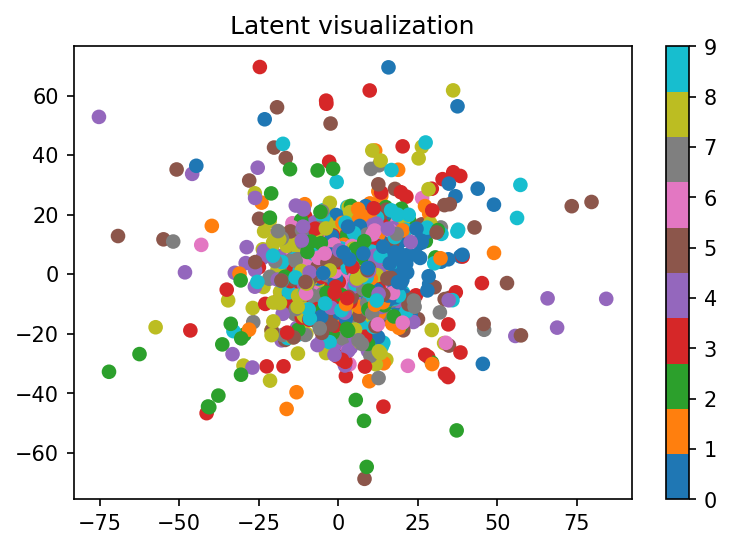

In [27]:
vae = main()

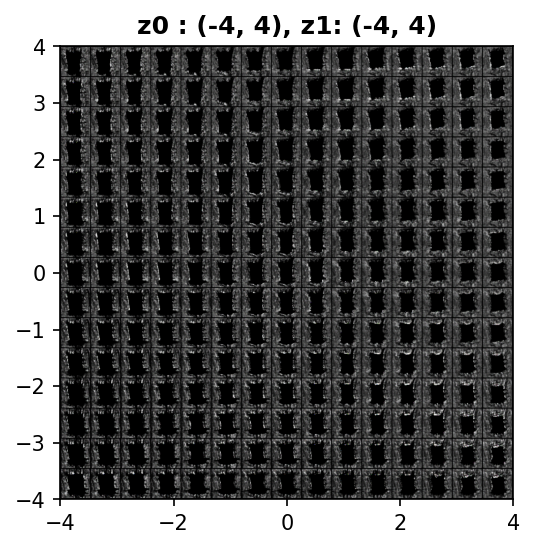

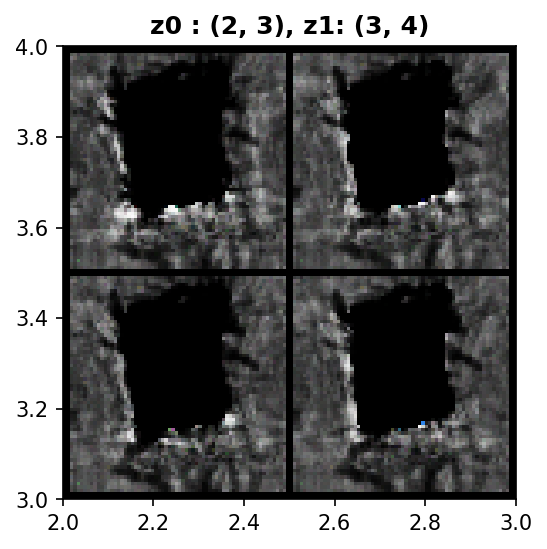

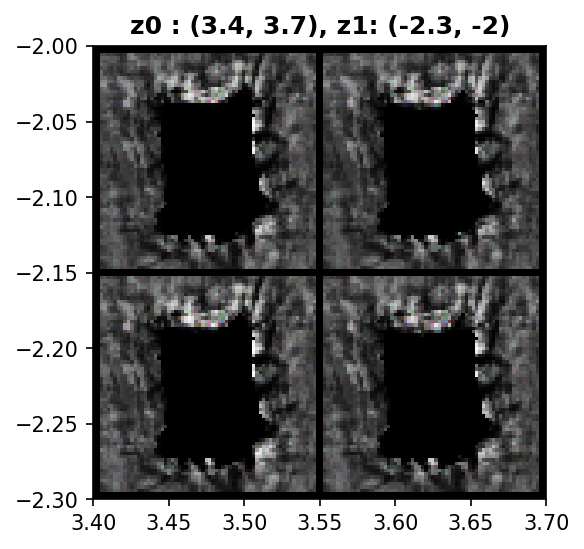

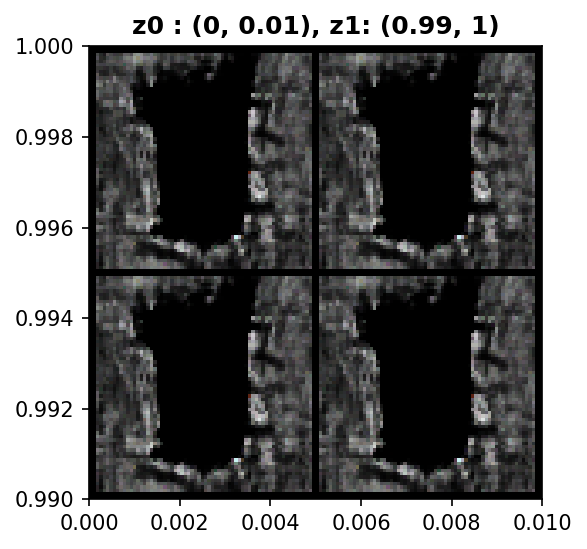

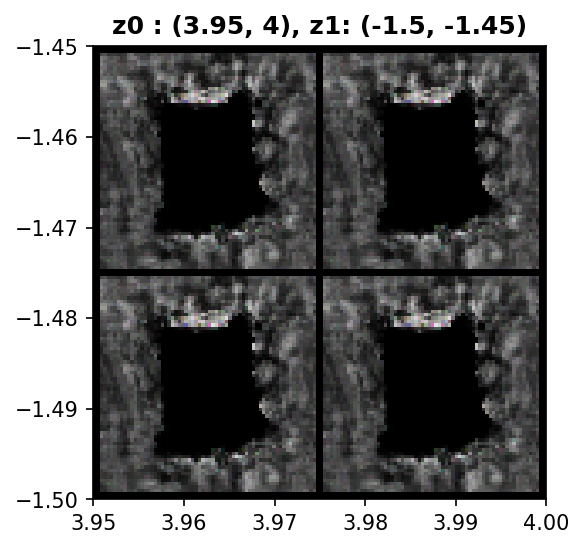

In [28]:
plot_reconstructed(vae,  r0=(-4, 4), r1=(-4, 4), n=15)
plt.show()
plot_reconstructed(vae,  r0=(2, 3), r1=(3, 4), n=2)
plt.show()
plot_reconstructed(vae,  r0=(3.4, 3.7), r1=(-2.3, -2), n=2)
plt.show()
plot_reconstructed(vae,  r0=(0, 0.01), r1=(0.99, 1), n=2)
plt.show()
plot_reconstructed(vae,  r0=(3.95, 4), r1=(-1.5, -1.45), n=2)
plt.show()